# Comparing Total Gas Masses Between Analyses

This notebook measures gas masses for the samples we are using to verify our method, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

The XXL, LoCuSS, and Lovisari samples all have gas mass measurements associated with them which we will compare to, but the SDSSRM-XCS sample does not (such measurements will be presented in an upcoming paper).

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, Unit
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from copy import deepcopy

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 20
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError

## Defining useful functions

In [2]:
# This function is used for getting axis limits for the the one to one comparison plots later
def find_lims(x_dat, y_dat, buffer=0.1):
    # A buffer of some percent (default 10) is added to the max and min values to make the plot 
    #  more easily readable
    lom = 1 - buffer
    him = 1 + buffer
    
    # Check if either are all NaNs
    if np.isnan(x_dat).all():
        x_dat = y_dat.copy()
    if np.isnan(y_dat).all():
        y_dat = x_dat.copy()
    
    # Reading out the values without errors
    x_vals = x_dat[:, 0]
    y_vals = y_dat[:, 0]
    
    # Depending on whether the input data has + and - errors, or just a standard deviation, depends how
    #  we find maximum and minimum values
    if x_dat.shape[1] == 3:
        # In this case upper and lower errors are present
        lb = x_vals-x_dat[:, 1]
        # Make sure that we don't count any NaN values, and don't count any negative values
        #  The lower errors are subtracted from the measurements, and upper values added to them
        #  Then max and mins are found 
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 2])]
    elif x_dat.shape[1] == 2:
        # The behaviour is largely the same as above, but for symmetrical errors
        lb = x_vals-x_dat[:, 1]
        x_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(x_vals+x_dat[:, 1])]
    
    if y_dat.shape[1] == 3:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 2])]
    elif y_dat.shape[1] == 2:
        lb = y_vals-y_dat[:, 1]
        y_lims = [np.nanmin(lb[np.where(lb>0)[0]]), np.nanmax(y_vals+y_dat[:, 1])]
    
    # Then find the minimum and maximum values from the min and max x and y data, and multiply by the buffer
    lims = Quantity([lom*min([x_lims[0], y_lims[0]]), him*max([x_lims[1], y_lims[1]])])
    
    # Return the limits for the square like for like comparison plot
    return lims

## Reading colour configuration file

In [3]:
samp_colours = pd.read_csv("samp_plot_colours.csv")

lov_colour = samp_colours[samp_colours['samp_name'] == 'lovisari'].iloc[0]['samp_colour']
xxl_colour = samp_colours[samp_colours['samp_name'] == 'xxl'].iloc[0]['samp_colour']
loc_colour = samp_colours[samp_colours['samp_name'] == 'locuss'].iloc[0]['samp_colour']

## Setting up cosmology

The LoCuSS and Lovisari analyses use the same concordance cosmology, but the XXL analysis of their bright cluster sample uses the WMAP9 results, and in case we wish to change anything for an individual sample later we define three separate cosmology objects to pass into our samples.

In [4]:
xxl_cosmo = WMAP9
locuss_cosmo = LambdaCDM(70, 0.3, 0.7)
lovisari_cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### XXL-100-GC

This is the sample of the brightest clusters in the XXL survey. It contains temperature and luminosity measurements, and will be a useful external comparison for XGA results, though the shallow XXL data may prove a challenge.

In [5]:
xxlgc100 = pd.read_csv("sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [ ]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=False, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [6]:
locuss = pd.read_csv("sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [ ]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

### Planck Selected with XMM follow-up

The Lovisari et al. sample was selected from Planck-eSZ, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [7]:
lovisari = pd.read_csv("sample_files/lovisari_planck_clusters.csv")

In [ ]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = lovisari['planck_ra'].values
dec = lovisari['planck_dec'].values
z = lovisari['z'].values
n = lovisari['name'].values
r500 = Quantity(lovisari['r500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the Lovisari sample
lovisari_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=lovisari_cosmo, load_fits=True, use_peak=False, 
                            clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

## Running PSF Correction

In [ ]:
rl_psf(xxl_srcs)
rl_psf(locuss_srcs)
rl_psf(lovisari_srcs)

## Reading in literature data

### Gas masses from literature

In [ ]:
xxl_lit_gms = [xxlgc100[xxlgc100['name'] == n].iloc[0][['mg500', 'mg500_err']].values*1e+13 
               for n in xxl_srcs.names]
xxl_lit_gms = Quantity(xxl_lit_gms, 'Msun')

lov_lit_gms = [lovisari[lovisari['name'] == n].iloc[0][['mg500', 'mg500-', 'mg500+']].values*1e+13
               for n in lovisari_srcs.names]
lov_lit_gms = Quantity(lov_lit_gms, 'Msun')

loc_lit_gms = [locuss[locuss['name'] == n].iloc[0][['x_mg500', 'x_mg500_err']].values
               for n in locuss_srcs.names]
loc_lit_gms = Quantity(loc_lit_gms, 'Msun')

### Conversion Temperatures

In [ ]:
xxl_conv_txs = []
loc_conv_txs = []
lov_conv_txs = []

for src in xxl_srcs:
    xxl_conv_txs.append(xxlgc100[xxlgc100['name'] == src.name].iloc[0]['T300kpc'])
    
for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

for src in lovisari_srcs:
    lov_conv_txs.append(lovisari[lovisari['name'] == src.name].iloc[0]['Tx'])

xxl_conv_txs = Quantity(xxl_conv_txs, 'keV')
loc_conv_txs = Quantity(loc_conv_txs, 'keV')
lov_conv_txs = Quantity(lov_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to 1.3$R_{500}$

In [ ]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

In [ ]:
xxl_beta_13_dp = inv_abel_fitted_model(xxl_srcs, 'beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))
lov_beta_13_dp = inv_abel_fitted_model(lovisari_srcs, 'beta', 'mcmc', lovisari_srcs.r500*1.3, 
                                       conv_temp=lov_conv_txs)
loc_beta_13_dp = inv_abel_fitted_model(locuss_srcs, 'beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

In [ ]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

In [ ]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to Lovisari profiles", total=len(lov_beta_13_dp)) as onwards:
    for dp in lov_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)


In [ ]:
xxl_beta_king_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_beta_13_dp)) as onwards:
    for dp in xxl_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", xxl_srcs[dp.src_name].r500)[0]
            xxl_beta_king_13_gm.append(gm)
        else:
            xxl_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

lov_beta_king_13_gm = []
with tqdm(desc="Calculating Lovisari gas masses", total=len(lov_beta_13_dp)) as onwards:
    for dp in lov_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", lovisari_srcs[dp.src_name].r500)[0]
            lov_beta_king_13_gm.append(gm)
        else:
            lov_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
loc_beta_king_13_gm = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
            loc_beta_king_13_gm.append(gm)
        else:
            loc_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
xxl_beta_king_13_gm = Quantity(xxl_beta_king_13_gm, 'Msun')
lov_beta_king_13_gm = Quantity(lov_beta_king_13_gm, 'Msun')
loc_beta_king_13_gm = Quantity(loc_beta_king_13_gm, 'Msun')

In [ ]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=3, figsize=(17, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_beta_king_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=xxl_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

# Add the a) label below this first plot
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_beta_king_13_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the last axis in the array of axes
ax = ax_arr[2]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_beta_king_13_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='c)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/xxl_lov_loc_beta_king_1.3r500_gm_comp.pdf")
plt.show()

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [ ]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

In [ ]:
xxl_dblbeta_13_dp = inv_abel_fitted_model(xxl_srcs, 'double_beta', 'mcmc', xxl_srcs.r500*1.3, 
                                       conv_temp=xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))
lov_dblbeta_13_dp = inv_abel_fitted_model(lovisari_srcs, 'double_beta', 'mcmc', lovisari_srcs.r500*1.3, 
                                       conv_temp=lov_conv_txs)
loc_dblbeta_13_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

In [ ]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

In [ ]:
with tqdm(desc="Fitting density model to XXL profiles", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to Lovisari profiles", total=len(lov_dblbeta_13_dp)) as onwards:
    for dp in lov_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)


In [ ]:
xxl_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating XXL gas masses", total=len(xxl_dblbeta_13_dp)) as onwards:
    for dp in xxl_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", xxl_srcs[dp.src_name].r500)[0]
            xxl_dblbeta_svikh_13_gm.append(gm)
        else:
            xxl_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

lov_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating Lovisari gas masses", total=len(lov_dblbeta_13_dp)) as onwards:
    for dp in lov_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", lovisari_srcs[dp.src_name].r500)[0]
            lov_dblbeta_svikh_13_gm.append(gm)
        else:
            lov_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
loc_dblbeta_svikh_13_gm = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_13_gm.append(gm)
        else:
            loc_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)        
        
xxl_dblbeta_svikh_13_gm = Quantity(xxl_dblbeta_svikh_13_gm, 'Msun')
lov_dblbeta_svikh_13_gm = Quantity(lov_dblbeta_svikh_13_gm, 'Msun')
loc_dblbeta_svikh_13_gm = Quantity(loc_dblbeta_svikh_13_gm, 'Msun')

In [ ]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=3, figsize=(17, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xxl_lit_gms, xxl_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xxl_lit_gms[:, 0].value, xxl_dblbeta_svikh_13_gm[:, 0].value, xerr=xxl_lit_gms[:, 1].value, 
             yerr=xxl_dblbeta_svikh_13_gm[:, 1:].T.value, fmt='x', 
             color=xxl_colour, capsize=2, label="XXL-100-GC")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

# Add the a) label below this first plot
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_dblbeta_svikh_13_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_dblbeta_svikh_13_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the last axis in the array of axes
ax = ax_arr[2]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_dblbeta_svikh_13_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_dblbeta_svikh_13_gm[:, 1].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='c)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/xxl_lov_loc_dblbeta_svikh_1.3r500_gm_comp.pdf")
plt.show()

## Gas Density Profile Generation and Comparison to Literature - from Annular Spectra

### Simplified Vikhlinin Profiles - out to $R_{500}$

In [ ]:
loc_annspec_10_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500, min_snr=30)
lov_annspec_10_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500, min_snr=30)

In [ ]:
dpath = "non_paper_figures/density_profiles/svikh_1r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_10_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_10_dp)) as onwards:
    for dp in lov_annspec_10_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.savefig(dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_10_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_10_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_10_dp)) as onwards:
    for dp in loc_annspec_10_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.savefig(dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_10_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_10_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_10_annspec_gm = Quantity(lov_svikh_10_annspec_gm, 'Msun').astype(float)
loc_svikh_10_annspec_gm = Quantity(loc_svikh_10_annspec_gm, 'Msun').astype(float)

In [ ]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_10_annspec_gm).value
lov_lims[1] = 5e+14

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_10_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_10_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_10_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_10_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_10_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

plt.tight_layout()

# Saving and plotting the resulting figure
plt.savefig("non_paper_figures/lov_loc_svikh_1r500_annspec_gm_comp.pdf")
plt.show()

### Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [ ]:
loc_annspec_13_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500*1.3, min_snr=30)
lov_annspec_13_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500*1.3, min_snr=30)

In [ ]:
lov_annspec_13_dp = [None]*len(lovisari_srcs)

In [ ]:
dpath = "non_paper_figures/density_profiles/svikh_13r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_13_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_13_dp)) as onwards:
    for dp in lov_annspec_13_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_13_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_13_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_13_dp)) as onwards:
    for dp in loc_annspec_13_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_13_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_13_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_13_annspec_gm = Quantity(lov_svikh_13_annspec_gm, 'Msun').astype(float)
loc_svikh_13_annspec_gm = Quantity(loc_svikh_13_annspec_gm, 'Msun').astype(float)

In [ ]:
rel_src = locuss_srcs[loc_annspec_13_dp[0].src_name]
loc_annspec_13_dp[0].view(draw_rads={'$R_{500}$': rel_src.r500}, xscale='linear')

In [ ]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_13_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_13_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_13_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_13_annspec_gm).value
loc_lims[1] = 0.5e+15
# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_13_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_13_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/lov_loc_svikh_13r500_annspec_gm_comp.pdf")
plt.show()

### Simplified Vikhlinin Profiles - out to 1.2$R_{500}$ 

In [ ]:
loc_annspec_12_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500*1.2, min_snr=30)
lov_annspec_12_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500*1.2, min_snr=30)

In [ ]:
lov_annspec_12_dp = [None]*len(lovisari_srcs)

In [ ]:
dpath = "non_paper_figures/density_profiles/svikh_12r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_12_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_12_dp)) as onwards:
    for dp in lov_annspec_12_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_12_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_12_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_12_dp)) as onwards:
    for dp in loc_annspec_12_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_12_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_12_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_12_annspec_gm = Quantity(lov_svikh_12_annspec_gm, 'Msun').astype(float)
loc_svikh_12_annspec_gm = Quantity(loc_svikh_12_annspec_gm, 'Msun').astype(float)

In [ ]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_12_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_12_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_12_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_12_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_12_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_12_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/lov_loc_svikh_12r500_annspec_gm_comp.pdf")
plt.show()

### Simplified Vikhlinin Profiles - out to 1.05$R_{500}$

In [ ]:
loc_annspec_105_dp = ann_spectra_apec_norm(locuss_srcs, locuss_srcs.r500*1.05, min_snr=30)
lov_annspec_105_dp = ann_spectra_apec_norm(lovisari_srcs, lovisari_srcs.r500*1.05, min_snr=30)

In [ ]:
dpath = "non_paper_figures/density_profiles/svikh_105r500_annspec/"
if not os.path.exists(dpath):
    os.makedirs(dpath+"lovisari")
    os.makedirs(dpath+"locuss") 

lov_svikh_105_annspec_gm = []
with tqdm(desc="Measuring Lovisari Gas Masses", total=len(lov_annspec_105_dp)) as onwards:
    for dp in lov_annspec_105_dp:
        if dp is not None:
            rel_src = lovisari_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"lovisari/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                lov_svikh_105_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                lov_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            lov_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

loc_svikh_105_annspec_gm = []
with tqdm(desc="Measuring LoCuSS Gas Masses", total=len(loc_annspec_105_dp)) as onwards:
    for dp in loc_annspec_105_dp:
        if dp is not None:
            rel_src = locuss_srcs[dp.src_name]
            # Fit a simplified Vikhlinin density profile
            dp.fit("simple_vikhlinin_dens", progress_bar=False)
            dp.view(save_path=dpath+"locuss/{}.pdf".format(rel_src.name))
            try:
                # Measure a gas mass within R500
                gm = dp.gas_mass("simple_vikhlinin_dens", rel_src.r500)[0]
                loc_svikh_105_annspec_gm.append(gm)
            except ModelNotAssociatedError:
                loc_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
        else:
            loc_svikh_105_annspec_gm.append([np.NaN, np.NaN, np.NaN])
    
        onwards.update(1)

lov_svikh_105_annspec_gm = Quantity(lov_svikh_105_annspec_gm, 'Msun').astype(float)
loc_svikh_105_annspec_gm = Quantity(loc_svikh_105_annspec_gm, 'Msun').astype(float)

In [ ]:
# Setting the y-position and font size of the a and b  labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 2 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=2, figsize=(12, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(lov_lit_gms, lov_svikh_105_annspec_gm).value
lov_lims[1] = 5e+14

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(lov_lit_gms[:, 0].value, lov_svikh_105_annspec_gm[:, 0].value, 
             xerr=lov_lit_gms[:, 1:].T.value, 
             yerr=lov_svikh_105_annspec_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al.")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(loc_lit_gms, loc_svikh_105_annspec_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(loc_lit_gms[:, 0].value, loc_svikh_105_annspec_gm[:, 0].value, 
             xerr=loc_lit_gms[:, 1].value, 
             yerr=loc_svikh_105_annspec_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.show()

# Comparing Total Gas Masses Between Analyses - XGA Centres

This repeats the analyses above, but using X-ray peaks as the central coordinates rather than the positions defined in the samples from literature.

## Reading in Sample Files and Declaring XGA ClusterSamples

$\color{red}{\text{NEED TO MENTION/PUBLISH THE OBSIDS THAT WE EXCLUDE FROM USE DUE TO DATA PROBLEMS LIKE FLARING}}$

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

The difference compared to earlier parts of this notebook is that hear we set `use_peak=True`, which allows XGA to find an X-ray peak position and use that as the default central coordinate. This is particularly relevant for the Lovisari sample, as currently the sample information from literature gives Planck positions, which can be quite offset.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.



### XXL-100-GC

This is the sample of the brightest clusters in the XXL survey. It contains temperature and luminosity measurements, and will be a useful external comparison for XGA results, though the shallow XXL data may prove a challenge.

In [8]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xc_xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=True, 
                            clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters:   0%|                                                      | 0/99 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-94 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   1%|▍                                             | 1/99 [00:08<13:09,  8.06s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-96 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:   2%|▉                                             | 2/99 [00:19<16:09, 10.00s/it]/mnt/pact/dt23

Setting up Galaxy Clusters:  17%|███████▋                                     | 17/99 [02:11<09:37,  7.04s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-98 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  18%|████████▏                                    | 18/99 [02:17<09:10,  6.80s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-99 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  19%|████████▋                                    | 19/99 [02:24<09:03,  6.80s/it]/mnt/pact/dt23

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-62 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  31%|██████████████                               | 31/99 [05:21<20:52, 18.42s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-1 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  32%|██████████████▌                              | 32/99 [05:36<19:16, 17.26s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observa

Setting up Galaxy Clusters:  42%|███████████████████                          | 42/99 [08:25<10:57, 11.54s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-22 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  43%|███████████████████▌                         | 43/99 [08:52<15:01, 16.10s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-27 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  44%|████████████████████                         | 44/99 [09:18<17:26, 19.03s/it]/mnt/pact/dt23

Setting up Galaxy Clusters:  58%|█████████████████████████▉                   | 57/99 [10:59<04:03,  5.79s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-528 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  60%|██████████████████████████▊                  | 59/99 [11:05<02:59,  4.48s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-526 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  61%|███████████████████████████▎                 | 60/99 [11:10<02:52,  4.43s/it]/mnt/pact/dt

Setting up Galaxy Clusters:  72%|████████████████████████████████▎            | 71/99 [12:09<02:47,  5.98s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-535 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  73%|████████████████████████████████▋            | 72/99 [12:14<02:38,  5.87s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0604873438, associated with source XLSSC-536
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0677820136, associated with source XLSSC-536
  warnings.

Setting up Galaxy Clusters:  87%|███████████████████████████████████████      | 86/99 [13:23<00:59,  4.61s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-549 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  89%|████████████████████████████████████████     | 88/99 [13:34<00:53,  4.88s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: XLSSC-537 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  90%|████████████████████████████████████████▍    | 89/99 [13:41<00:53,  5.35s/it]/mnt/pact/dt

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [9]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
xc_locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                               use_peak=True, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)  

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [02:52<05:26, 10.21s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [03:44<05:21, 11.92s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  54%|███████████████████████▊                    | 27/50 [04:06<03:00,  7.86s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:91: UserWarning: Source Abell1682 does not appear to have any XMM data, and

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for Abell2219 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  89%|████████████████████████████████████████     | 41/46 [05:40<01:04, 12.93s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:109: UserWarning: There are 1 alternative matches for observation 0093031601, associated with source Abell2261
  warnings.warn("There are {0} alternative matches for observation {1}, associated with "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: Abell2261 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fit

### Planck Selected with XMM follow-up

The Lovisari et al. sample was selected from Planck-eSZ, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [10]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = lovisari['planck_ra'].values
dec = lovisari['planck_dec'].values
z = lovisari['z'].values
n = lovisari['name'].values
r500 = Quantity(lovisari['r500'].values, 'kpc')

# Declaring the actual ClusterSample instance for the Lovisari sample
xc_lovisari_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=lovisari_cosmo, load_fits=True, use_peak=True, 
                                 clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  50%|█████████████████████▌                     | 60/120 [08:41<06:18,  6.31s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.17-21.91 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0675470101/0675470101_mos2_G226.17-21.91_ra88.262_dec-21.062_ri0.0483332993719956_ro0.05437496179349506_grpTrue_mincnt5_ident72837747_6_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Declaring BaseSource Sample:  51%|█████████████████████▊                     | 61/120 [08:55<08:19,  8.46s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTr

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.1752082510082009_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarni

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0105660101/0105660101_mos2_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning:

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G080.38-33.20 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profile fit for G080.38-33.20 was not successful, or no matching spectrum has been loaded, so it cannot be read in
  warnings.warn("A previous annular spectra profile fit for {src} was not successful, or no "
Setting up Galaxy Clusters:  29%|████████████▊                               | 35/120 [04:55<08:06,  5.73s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G093.91+34.90 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warning

Setting up Galaxy Clusters:  51%|██████████████████████▎                     | 61/120 [07:49<08:18,  8.45s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_mos2_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0551280201/0551280201_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded i

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_mos1_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G226.24+76.76 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0502690101/0502690101_pn_G226.24x76.76_ra178.812_dec23.387_ri0.0_ro0.16191659058688912_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarnin

Setting up Galaxy Clusters:  62%|███████████████████████████▌                | 75/120 [09:25<03:54,  5.21s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0603050201/0603050201_mos1_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: G252.96-56.05 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/xga_output/0603050201/0603050201_pn_G252.96-56.05_ra49.515_dec-44.263_ri0.0_ro0.2561665126045533_grpTrue_mincnt5_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in 

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:164: UserWarning: After applying the criteria for the minimum amount of cluster required on an observation, G272.10-40.15 cannot be declared as all potential observations were removed
  warn("After applying the criteria for the minimum amount of cluster required on an "
Setting up Galaxy Clusters:  77%|█████████████████████████████████▋          | 92/120 [11:25<03:02,  6.51s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: G282.49+65.17 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  84%|████████████████████████████████████▏      | 101/120 [12:22<02:08,  6.76s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:963: UserWarning: A previous annular spectra profi

### Reading in Sample Values

In [11]:
xc_xxl_lit_gms = [xxlgc100[xxlgc100['name'] == n].iloc[0][['mg500', 'mg500_err']].values*1e+13 
               for n in xc_xxl_srcs.names]
xc_xxl_lit_gms = Quantity(xc_xxl_lit_gms, 'Msun')

xc_lov_lit_gms = [lovisari[lovisari['name'] == n].iloc[0][['mg500', 'mg500-', 'mg500+']].values*1e+13
               for n in xc_lovisari_srcs.names]
xc_lov_lit_gms = Quantity(xc_lov_lit_gms, 'Msun')

xc_loc_lit_gms = [locuss[locuss['name'] == n].iloc[0][['x_mg500', 'x_mg500_err']].values
               for n in xc_locuss_srcs.names]
xc_loc_lit_gms = Quantity(xc_loc_lit_gms, 'Msun')

In [13]:
xc_xxl_conv_txs = []
xc_loc_conv_txs = []
xc_lov_conv_txs = []

for src in xc_xxl_srcs:
    xc_xxl_conv_txs.append(xxlgc100[xxlgc100['name'] == src.name].iloc[0]['T300kpc'])
    
for src in xc_locuss_srcs:
    xc_loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

for src in xc_lovisari_srcs:
    xc_lov_conv_txs.append(lovisari[lovisari['name'] == src.name].iloc[0]['Tx'])

xc_xxl_conv_txs = Quantity(xc_xxl_conv_txs, 'keV')
xc_loc_conv_txs = Quantity(xc_loc_conv_txs, 'keV')
xc_lov_conv_txs = Quantity(xc_lov_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

In [14]:
rl_psf(xc_xxl_srcs)
rl_psf(xc_locuss_srcs)
rl_psf(xc_lovisari_srcs)

Generating products of type(s) image: 100%|█████████████████████████████████████| 3/3 [00:01<00:00,  2.75it/s]


### Beta and King Profiles - out to 1.3$R_{500}$

In [15]:
xc_xxl_beta_13_dp = inv_abel_fitted_model(xc_xxl_srcs, 'beta', 'mcmc', xc_xxl_srcs.r500*1.3, 
                                       conv_temp=xc_xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))
xc_lov_beta_13_dp = inv_abel_fitted_model(xc_lovisari_srcs, 'beta', 'mcmc', xc_lovisari_srcs.r500*1.3, 
                                       conv_temp=xc_lov_conv_txs)
xc_loc_beta_13_dp = inv_abel_fitted_model(xc_locuss_srcs, 'beta', 'mcmc', xc_locuss_srcs.r500*1.3, 
                                       conv_temp=xc_loc_conv_txs)

Running XSPEC Simulations: 100%|██████████████████████████████████████████████| 96/96 [00:43<00:00,  2.21it/s]
Fitting data, inverse Abel transforming, and measuring densities:  14%|█      | 14/97 [04:46<28:35, 20.66s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 37/97 [13:25<25:01, 25.03s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  resul

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 256.63091562  940.70249745 1344.47371264]


Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 44/97 [15:50<18:31, 20.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 246.77326865  885.42801054 1201.62697545]


Fitting data, inverse Abel transforming, and measuring densities:  47%|███▎   | 46/97 [16:31<17:42, 20.84s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-88's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  62%|████▎  | 60/97 [21:31<13:18, 21.58s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/s

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2077.73047977 1389.49547803 1250.31552388]


Fitting data, inverse Abel transforming, and measuring densities:  93%|████▋| 111/119 [44:37<03:12, 24.12s/it]
Running XSPEC Simulations: 100%|██████████████████████████████████████████████| 46/46 [00:41<00:00,  1.11it/s]
Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 46/46 [18:05<00:00, 23.59s/it]


In [19]:
xc_xxl_beta_king_13_gm = []
xc_lov_beta_king_13_gm = []
xc_loc_beta_king_13_gm = []

with tqdm(desc="Fitting density model to XXL profiles/calculating masses", total=len(xc_xxl_beta_13_dp)) as onwards:
    for dp in xc_xxl_beta_13_dp:
        if dp is not None:
            rel_src = xc_xxl_srcs[dp.src_name]
            dp.fit('king', progress_bar=False)
            xc_xxl_beta_king_13_gm.append(dp.gas_mass('king', rel_src.r500)[0])
        else:
            xc_xxl_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

with tqdm(desc="Fitting density model to Lovisari profiles/calculating masses", 
          total=len(xc_lov_beta_13_dp)) as onwards:
    for dp in xc_lov_beta_13_dp:
        if dp is not None:
            rel_src = xc_lovisari_srcs[dp.src_name]
            dp.fit('king', progress_bar=False)
            xc_lov_beta_king_13_gm.append(dp.gas_mass('king', rel_src.r500)[0])
        else:
            xc_lov_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

with tqdm(desc="Fitting density model to LoCuSS profiles/calculating masses", 
          total=len(xc_loc_beta_13_dp)) as onwards:
    for dp in xc_loc_beta_13_dp:
        if dp is not None:
            rel_src = xc_locuss_srcs[dp.src_name]
            dp.fit('king', progress_bar=False)
            xc_loc_beta_king_13_gm.append(dp.gas_mass('king', rel_src.r500)[0])
        else:
            xc_loc_beta_king_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

xc_xxl_beta_king_13_gm = Quantity(xc_xxl_beta_king_13_gm, 'Msun')
xc_lov_beta_king_13_gm = Quantity(xc_lov_beta_king_13_gm, 'Msun')
xc_loc_beta_king_13_gm = Quantity(xc_loc_beta_king_13_gm, 'Msun')

Fitting density model to XXL profiles/calculating masses:  40%|██████         | 39/97 [20:26<26:29, 27.40s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:423: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, 0, outer_radius.value,
Fitting density model to XXL profiles/calculating masses:  44%|██████▋        | 43/97 [22:33<27:34, 30.64s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:423: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, 0, outer_radius.value,
Fitting density model to XXL profiles/calculating masses:  82%|████████████▎  | 80/97 [41:53<09:21, 33.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [423.61019226 720.32172159 822.2416423 ]


Fitting density model to XXL profiles/calculating masses: 100%|███████████████| 97/97 [49:58<00:00, 30.91s/it]
Fitting density model to Lovisari profiles/calculating masses:  97%|█████▊| 115/119 [1:04:59<02:07, 31.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [400.49923939 611.28621045 766.42464147]


Fitting density model to Lovisari profiles/calculating masses: 100%|██████| 119/119 [1:07:26<00:00, 34.01s/it]
Fitting density model to LoCuSS profiles/calculating masses: 100%|████████████| 46/46 [27:05<00:00, 35.34s/it]


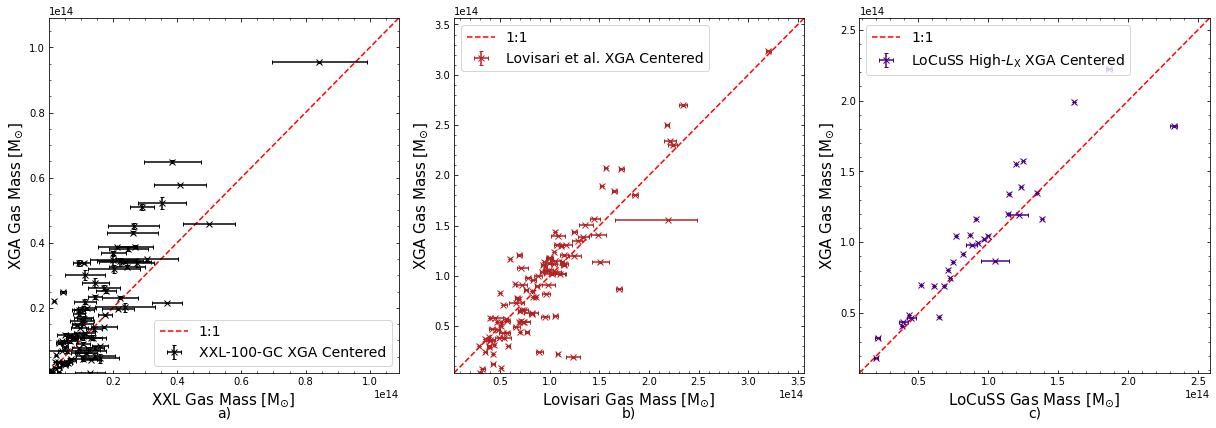

In [25]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=3, figsize=(17, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xc_xxl_lit_gms, xc_xxl_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xc_xxl_lit_gms[:, 0].value, xc_xxl_beta_king_13_gm[:, 0].value, xerr=xc_xxl_lit_gms[:, 1].value, 
             yerr=xc_xxl_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=xxl_colour, capsize=2, label="XXL-100-GC XGA Centered")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

# Add the a) label below this first plot
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(xc_lov_lit_gms, xc_lov_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xc_lov_lit_gms[:, 0].value, xc_lov_beta_king_13_gm[:, 0].value, 
             xerr=xc_lov_lit_gms[:, 1:].T.value, 
             yerr=xc_lov_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al. XGA Centered")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the last axis in the array of axes
ax = ax_arr[2]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(xc_loc_lit_gms, xc_loc_beta_king_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xc_loc_lit_gms[:, 0].value, xc_loc_beta_king_13_gm[:, 0].value, 
             xerr=xc_loc_lit_gms[:, 1].value, 
             yerr=xc_loc_beta_king_13_gm[:, 1:].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$ XGA Centered")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='c)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/xxl_lov_loc_beta_king_1.3r500_xgacent_gm_comp.pdf")
plt.show()

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [16]:
xc_xxl_dblbeta_13_dp = inv_abel_fitted_model(xc_xxl_srcs, 'double_beta', 'mcmc', xc_xxl_srcs.r500*1.3, 
                                       conv_temp=xc_xxl_conv_txs, conv_outer_radius=Quantity(300, 'kpc'))
xc_lov_dblbeta_13_dp = inv_abel_fitted_model(xc_lovisari_srcs, 'double_beta', 'mcmc', xc_lovisari_srcs.r500*1.3, 
                                       conv_temp=xc_lov_conv_txs)
xc_loc_dblbeta_13_dp = inv_abel_fitted_model(xc_locuss_srcs, 'double_beta', 'mcmc', xc_locuss_srcs.r500*1.3, 
                                       conv_temp=xc_loc_conv_txs)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|                | 0/97 [00:00<?, ?it/s]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-94's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   1%|        | 1/97 [00:19<31:36, 19.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 410.58233672  977.49712911 1123.921161    297.29216655  714.38322646
 1156.92653912]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-96's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 2/97 [00:41<33:23, 21.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [322.49555113 406.53018109 609.43969206 287.39905471 433.86508005
 550.62886367]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-102's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   3%|▏       | 3/97 [01:01<32:22, 20.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [360.45294668 692.56569496 508.89039585 276.22488395 578.74994388
 472.34451012]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-106's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 4/97 [01:23<32:44, 21.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 482.13863043  872.36090378 1465.47728331  275.73601588  343.89842363
 1383.15938935]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-107's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   5%|▍       | 5/97 [01:44<31:58, 20.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [324.39223782 499.71412715 629.64706368 375.19706399 383.41045499
 480.59476628]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-100's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   6%|▍       | 6/97 [02:04<31:08, 20.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 771.10848139 2105.60651056 1365.07730422  547.89452056 1377.38372373
 1092.54217431]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 7/97 [02:26<31:38, 21.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 457.35601482 1009.81775152 2106.02851667  923.4837185  1678.0027769
 1791.39492606]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-108's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   8%|▋       | 8/97 [02:46<30:59, 20.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [492.34023784 666.97024962 640.88986637 388.17246831 686.76950143
 570.48524042]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-95's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 9/97 [03:06<30:20, 20.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 379.96648542 1264.17099515  945.00233663  431.10660604  575.98989872
  807.79666012]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-92's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  10%|▋      | 10/97 [03:27<29:41, 20.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [397.65956265 654.37911454 552.99892641 406.97601699 472.95150719
 513.98960894]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-101's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  11%|▊      | 11/97 [03:47<29:29, 20.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [529.56254891 906.39456005 850.7939285  487.4229528  737.44542494
 637.59396662]


Fitting data, inverse Abel transforming, and measuring densities:  12%|▊      | 12/97 [04:08<29:04, 20.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [451.52109294 692.43555941 710.7619005  334.29823443 683.98885532
 928.19938294]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-112's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  13%|▉      | 13/97 [04:30<29:23, 20.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [428.06960723 475.90257988 687.67127723 370.55975065 567.32122634
 626.26941804]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-83's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  14%|█      | 14/97 [04:51<29:02, 21.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 507.26300182  292.29407235 1602.39172824  220.98766457  411.45480736
 1277.98160207]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-84's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  15%|█      | 15/97 [05:10<28:05, 20.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 815.35074807 1340.36838143  991.34498042  819.43658341  936.98740467
  682.89762983]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-85's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  16%|█▏     | 16/97 [05:31<27:51, 20.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [352.44953875 502.17296564 465.81839381 338.86692563 517.85889689
 471.48023126]


Fitting data, inverse Abel transforming, and measuring densities:  18%|█▏     | 17/97 [05:55<28:50, 21.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 377.60918417  764.52850468 1591.85706896 1230.35719722  755.99027078
  957.9396617 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-98's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  19%|█▎     | 18/97 [06:17<28:38, 21.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 408.90608143 1066.40434103 1671.16083762  773.5509092  1266.04563624
 1456.05122667]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-99's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  20%|█▎     | 19/97 [06:38<28:05, 21.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [362.5473404  591.51468266 625.10649356 383.18701009 542.76802157
 386.69817607]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-97's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  21%|█▍     | 20/97 [06:59<27:27, 21.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 562.91808554  880.05349512 1705.56080726  570.1683647  1108.26886741
 1690.99398809]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-110's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  22%|█▌     | 21/97 [07:20<26:55, 21.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 289.88462023  791.83217097 1853.31477294  840.50818464 1201.84617007
 1427.89108647]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [225.76983441 688.98337006 642.05626937 185.23601424 326.88650913
 552.14961289]


Fitting data, inverse Abel transforming, and measuring densities:  23%|█▌     | 22/97 [07:47<28:48, 23.05s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-72's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  24%|█▋     | 23/97 [08:08<27:35, 22.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1106.23491704 1099.99434574 1312.46692681 1518.4210589  1244.05718156
 1311.83121712]


Fitting data, inverse Abel transforming, and measuring densities:  25%|█▋     | 24/97 [08:31<27:31, 22.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [199.85378179 213.2792145  590.05893646 216.70143004 199.45959448
 205.57555938]


Fitting data, inverse Abel transforming, and measuring densities:  26%|█▊     | 25/97 [08:58<28:32, 23.78s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-23's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  27%|█▉     | 26/97 [09:18<26:47, 22.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 711.03973847 1187.330345   1080.14461007  655.35504891  939.80770805
  983.84669981]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 27/97 [09:42<26:57, 23.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 477.5582065   555.85101745 1477.19223186 1413.92159376 1519.78507606
 1424.37500581]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-36's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  29%|██     | 28/97 [10:04<26:07, 22.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 584.32766434  951.10924317 1771.80994705  926.95263831 1334.93665821
 1747.30116562]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██     | 29/97 [10:27<25:44, 22.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 986.53789958 1266.65100895 1265.41991545 1222.83390674 1342.50734592
 1667.82779799]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [226.86538399 461.30882895 772.29924803 259.68960523 345.30178436
 417.58830711]


Fitting data, inverse Abel transforming, and measuring densities:  31%|██▏    | 30/97 [10:52<26:12, 23.47s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-1's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  32%|██▏    | 31/97 [11:13<25:00, 22.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1030.48156973 1276.39098398 1612.06294855 1110.85406766 1228.41385108
 1387.25125854]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [396.63613768 639.707694   534.14142804 398.16578389 650.70574732
 683.08402166]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-54's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  34%|██▍    | 33/97 [12:07<26:35, 24.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 331.93155344  443.15705839 1053.11692368  973.00032659 1066.73514174
  716.53597838]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 913.67250005  971.47307877 1476.55514109 1415.35415624 1460.49999158
  912.18665167]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 36/97 [13:24<25:34, 25.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [401.44797997 550.55776478 578.61789824 617.85525403 714.81758494
 854.19502216]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 517.80890946 1582.14020103  955.96710589  603.453665   1623.64972652
  969.42342158]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-11's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  38%|██▋    | 37/97 [13:53<26:07, 26.13s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-52's density

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 552.1839322  1397.00416539  769.05989214  697.08598037 1197.37269355
 1023.16297518]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▊    | 39/97 [14:35<22:50, 23.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 998.04697597 2104.76015961 1442.62454605 1309.57572359 1661.52223428
 1897.86581511]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-103's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  41%|██▉    | 40/97 [14:55<21:26, 22.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 636.13648694 1722.25316858 1366.26529261  986.43690894 1923.67108312
 2139.31670785]


Fitting data, inverse Abel transforming, and measuring densities:  42%|██▉    | 41/97 [15:16<20:31, 21.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1350.89087567 1411.98151626 1184.78006076 1253.34969556 1282.64216414
 1378.1315702 ]


Fitting data, inverse Abel transforming, and measuring densities:  43%|███    | 42/97 [15:40<20:45, 22.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [605.41988462 885.99797239 731.38740225 726.156796   840.00745145
 956.863704  ]


Fitting data, inverse Abel transforming, and measuring densities:  44%|███    | 43/97 [16:03<20:22, 22.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 550.89584012 1081.97938772 1307.671253    485.39069019  749.17458211
  511.64544539]


Fitting data, inverse Abel transforming, and measuring densities:  45%|███▏   | 44/97 [16:24<19:32, 22.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 454.37763464  631.13000652 1044.59992034  465.12096394  817.17161128
  669.67734334]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-89's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  46%|███▏   | 45/97 [16:44<18:41, 21.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [294.25934284 464.24092757 613.39101839 239.82668824 670.23585618
 614.0397646 ]


Fitting data, inverse Abel transforming, and measuring densities:  47%|███▎   | 46/97 [17:06<18:26, 21.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 554.22903144  684.89773757 1131.72061434  470.56270754  445.98928756
  383.30869221]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-88's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  48%|███▍   | 47/97 [17:26<17:32, 21.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 439.0038789   839.97083173 1095.77450198  529.07087546 1010.98333486
  730.34414311]


Fitting data, inverse Abel transforming, and measuring densities:  49%|███▍   | 48/97 [17:51<18:11, 22.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 220.59291372  558.53509379 1635.82643744 1559.74316203 1647.21196025
  301.54070471]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [221.94108779 330.51063064 427.13212417 143.71217861 160.16615381
 147.55666576]


Fitting data, inverse Abel transforming, and measuring densities:  52%|███▌   | 50/97 [18:39<17:58, 22.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 411.13621366 1039.61042773  590.72249616  483.51362754  481.71992107
  877.84496834]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▋   | 51/97 [19:03<17:51, 23.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [275.17687532 402.12935108 451.88684775 382.18312552 471.3253509
 734.04164361]


Fitting data, inverse Abel transforming, and measuring densities:  54%|███▊   | 52/97 [19:27<17:42, 23.60s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-501's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  55%|███▊   | 53/97 [19:48<16:45, 22.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [366.67496983 622.48625963 677.41786345 376.1864227  645.35098962
 681.91150773]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▉   | 54/97 [20:12<16:38, 23.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 369.67448997  384.08099421 1654.33872873 1230.70125372  700.10338171
  266.94914707]


Fitting data, inverse Abel transforming, and measuring densities:  57%|███▉   | 55/97 [20:33<15:42, 22.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 824.69087102 1316.81241499 1262.19985174  813.58196847 1250.42345705
 1271.57124232]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-528's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  58%|████   | 56/97 [20:54<14:59, 21.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 420.39646478 1009.46607985  740.60796433  341.73565964  503.8792141
  714.17368054]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-529's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  59%|████   | 57/97 [21:14<14:21, 21.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 421.30896703  516.86512515 1427.95725282  224.54340492  377.1551477
 1226.59225005]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-526's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  60%|████▏  | 58/97 [21:35<13:51, 21.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [427.12182791 557.74791828 670.10851411 387.14222861 525.05304227
 472.05135532]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [200.4483242  300.29589491 520.536729   167.37148531 162.37487281
 148.18113273]


Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 59/97 [22:03<14:43, 23.26s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-518's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  62%|████▎  | 60/97 [22:23<13:48, 22.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 596.57494084 1128.32575202 1428.45366291  461.48890458  990.01369549
 1415.72173885]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-531's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  63%|████▍  | 61/97 [22:43<12:56, 21.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 437.49029299  678.45362518 1076.26615693  339.76047517  754.61439897
  699.35673558]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-534's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  64%|████▍  | 62/97 [23:03<12:20, 21.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 367.17411454 1141.27886461 1440.00948701  262.82443908  480.98915339
 1307.05748531]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-517's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  66%|████▌  | 64/97 [23:44<11:28, 20.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [354.9078536  851.29874869 854.55419517 292.54234923 821.50850032
 768.90531125]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-503's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  67%|████▋  | 65/97 [24:05<11:08, 20.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 489.85736339 1006.22664549 1735.51246811 1023.91868102 1437.00162751
 1492.56538018]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-545's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  68%|████▊  | 66/97 [24:26<10:43, 20.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 488.7790488  1412.50354969 1388.43830994  220.50331519  374.0841862
 1176.36458027]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-514's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  69%|████▊  | 67/97 [24:47<10:25, 20.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [434.79244266 667.84542839 722.17405347 476.71125259 880.767767
 892.2378741 ]


Fitting data, inverse Abel transforming, and measuring densities:  70%|████▉  | 68/97 [25:11<10:35, 21.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [292.53921491 302.2949644  339.19643058 315.94891816 342.64803681
 458.70101565]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-547's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  71%|████▉  | 69/97 [25:33<10:10, 21.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 417.48019319  488.98241633 2005.17858676  236.89085908  329.78594915
 1699.4352396 ]


Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 70/97 [25:54<09:48, 21.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1208.33291742 1387.18134307 1551.61205142 1455.09005921 1255.246453
 1556.55616352]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-536's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  73%|█████  | 71/97 [26:16<09:21, 21.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [257.34036593 542.33850943 473.05930241 264.94605265 425.39645761
 379.04997475]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-522's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 72/97 [26:37<09:01, 21.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 537.77591009 1912.93067037 2274.1355575  1852.17044892 1749.0162716
 2177.22859591]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [128.57350074 321.32375251 413.91764781 192.35750843 169.4802635
 185.3515604 ]


Fitting data, inverse Abel transforming, and measuring densities:  75%|█████▎ | 73/97 [27:04<09:13, 23.07s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-521's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 74/97 [27:24<08:28, 22.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [280.19505581 680.52814312 385.55770914 280.27464021 700.12442283
 421.79769435]


Fitting data, inverse Abel transforming, and measuring densities:  77%|█████▍ | 75/97 [27:53<08:51, 24.15s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-506's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 76/97 [28:13<08:01, 22.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [354.43945873 623.22310709 634.44952866 267.75915632 559.02664634
 563.75511278]


Fitting data, inverse Abel transforming, and measuring densities:  79%|█████▌ | 77/97 [28:33<07:23, 22.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [428.1179877  693.02391285 536.5758176  365.1964025  567.59866495
 377.52110643]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-512's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  80%|█████▋ | 78/97 [28:54<06:57, 21.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 708.15148334  469.89428591 1189.97014126  207.89058069  287.15889312
 1079.03825359]


Fitting data, inverse Abel transforming, and measuring densities:  81%|█████▋ | 79/97 [29:19<06:48, 22.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [186.3945262  254.78190688 524.37427397 198.14663633 194.51707644
 147.53820558]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-532's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  82%|█████▊ | 80/97 [29:40<06:15, 22.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [228.04860296 449.66696275 436.38632838 264.76119967 321.86771286
 345.92913792]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-519's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  84%|█████▊ | 81/97 [30:02<05:53, 22.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [143.74286877 295.92491477 901.67420102 880.23837242 813.71672492
 152.8186171 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-524's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  85%|█████▉ | 82/97 [30:22<05:22, 21.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 479.67945832 1055.41623007 1004.21051155  587.13232391  856.2112354
  551.81951272]


Fitting data, inverse Abel transforming, and measuring densities:  86%|█████▉ | 83/97 [30:48<05:20, 22.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [582.66024014 353.6926825  568.32602863 440.57747974 480.91462093
 706.80546139]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-507's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  87%|██████ | 84/97 [31:07<04:42, 21.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [397.39810301 608.82515981 508.24007015 347.71802829 664.64180183
 595.58166244]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-549's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  88%|██████▏| 85/97 [31:27<04:14, 21.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 384.58386712 1277.96095798 1787.79079989  705.07068656 1269.18285367
 1757.8766521 ]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-516's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  89%|██████▏| 86/97 [31:46<03:46, 20.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 434.76265568  696.05859523 1084.35261537  422.15472032  950.69570064
  825.52808623]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-537's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  90%|██████▎| 87/97 [32:07<03:26, 20.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [495.75798772 874.56706554 942.34544401 462.82042022 738.17007636
 550.12847275]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-548's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  91%|██████▎| 88/97 [32:27<03:03, 20.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [266.24621734 395.90128618 962.51105072 222.82879599 375.330377
 467.59066318]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-538's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  92%|██████▍| 89/97 [32:48<02:44, 20.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 319.93823503 1040.70333683 2062.23712531  221.58313487  260.18619353
 1667.14553952]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-543's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▍| 90/97 [33:08<02:24, 20.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [461.93847387 884.61584183 596.42335949 560.25695202 843.38460553
 718.64938897]


Fitting data, inverse Abel transforming, and measuring densities:  94%|██████▌| 91/97 [33:32<02:08, 21.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 457.25370248  983.37243127  554.19679052  748.19269677  926.54751405
 1268.06366647]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-508's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  95%|██████▋| 92/97 [33:52<01:46, 21.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [477.15231942 887.84943175 779.79701136 475.55501922 846.14713649
 772.94891306]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 93/97 [34:14<01:24, 21.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 399.42955599 1463.9115929  1527.93691665  409.27657073  483.96223867
 1426.46706137]


Fitting data, inverse Abel transforming, and measuring densities:  97%|██████▊| 94/97 [34:34<01:03, 21.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [307.38366275 772.68811213 607.28473697 277.89008316 794.79630613
 426.39519759]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 95/97 [34:55<00:41, 20.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [311.97598696 572.97049709 712.15785888 378.23029335 382.59196997
 342.92589608]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of XLSSC-510's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  99%|██████▉| 96/97 [35:16<00:20, 20.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [415.22641819 682.15613052 606.3634676  294.39407231 620.47282554
 491.6838629 ]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 97/97 [35:38<00:00, 22.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [232.13943414 299.33450482 744.91532901 273.37084856 221.96325677
 261.71528111]



/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   2%|       | 2/119 [00:57<56:40, 29.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [303.85300507 634.55420299 974.03145183 183.7765968  186.96742292
 180.4765273 ]


Fitting data, inverse Abel transforming, and measuring densities:   3%|▏      | 3/119 [01:27<57:10, 29.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1700.06907786  511.35487472 1833.69012061 1176.97419646  889.37695749
 1831.26942095]


Fitting data, inverse Abel transforming, and measuring densities:   3%|▏      | 4/119 [01:53<53:31, 27.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [672.54924498 707.18170203 510.40402715 795.58890849 718.19307752
 550.31027823]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎      | 5/119 [02:23<54:46, 28.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [425.98363259 396.06458143 305.13391411 185.34782079 206.1489375
 297.73722467]


Fitting data, inverse Abel transforming, and measuring densities:   6%|▍      | 7/119 [03:20<52:48, 28.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [624.04780121 743.80950318 610.28034979 895.27759323 854.90109069
 629.84113917]


Fitting data, inverse Abel transforming, and measuring densities:   8%|▌      | 9/119 [04:18<52:58, 28.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1731.78515306  826.98077458 2230.60978576 2045.59782819 2146.48586032
 2236.70051415]


Fitting data, inverse Abel transforming, and measuring densities:   8%|▌     | 10/119 [04:44<50:30, 27.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [113.3189738  111.93007554 108.11025134 991.87345356 166.69797444
 164.55352842]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G042.82+56.61's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  10%|▌     | 12/119 [05:43<50:18, 28.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [211.866357   460.96763949 162.29191295 156.61359609 140.18766878
 219.17124985]


Fitting data, inverse Abel transforming, and measuring densities:  14%|▊     | 17/119 [08:20<52:16, 30.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 951.97827087 1331.93452707 1007.4078151   754.47727876  543.88649395
 1282.17715746]


Fitting data, inverse Abel transforming, and measuring densities:  15%|▉     | 18/119 [08:44<48:09, 28.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 401.86473266  894.12312819 1252.3589443   197.71592041  196.23451099
  241.59112515]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█     | 20/119 [09:39<45:47, 27.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [148.05995579 504.28752868 127.35344019 243.18108312 281.49860154
 295.25496208]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▏    | 23/119 [11:09<47:19, 29.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [296.9792079  704.67527012 696.28315528 202.31420242 205.82124294
 263.10261576]


Fitting data, inverse Abel transforming, and measuring densities:  20%|█▏    | 24/119 [11:34<44:37, 28.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [512.90156338 434.79337928 467.36556681 263.73836954 278.31721546
 420.57710104]


Fitting data, inverse Abel transforming, and measuring densities:  21%|█▎    | 25/119 [12:04<44:57, 28.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [474.25594269 454.55703683 262.29383961 235.38223105 280.30224308
 341.55024818]


Fitting data, inverse Abel transforming, and measuring densities:  24%|█▍    | 29/119 [14:07<44:26, 29.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [573.55622724 539.16570236 490.34589103 335.32248979 402.55514259
 508.14555879]


Fitting data, inverse Abel transforming, and measuring densities:  25%|█▌    | 30/119 [14:33<42:15, 28.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 910.06318263  765.0216946  1551.60002949 1552.18639586 1677.40322649
 1529.29153428]


Fitting data, inverse Abel transforming, and measuring densities:  27%|█▌    | 32/119 [15:26<39:57, 27.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2008.32126321 1298.47891611 2022.18642533 1642.45792062 1852.78486376
 1978.37123445]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▋    | 33/119 [15:52<38:54, 27.15s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G096.87+24.21's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  29%|█▋    | 34/119 [16:13<35:47, 25.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [281.58875805 498.49313706 454.84679918 273.4362275  420.82025659
 445.10884951]


Fitting data, inverse Abel transforming, and measuring densities:  29%|█▊    | 35/119 [16:42<36:57, 26.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 610.76443901 1352.55214715 1478.97335451  415.89675335  389.71165676
  378.70645041]


Fitting data, inverse Abel transforming, and measuring densities:  31%|█▊    | 37/119 [17:34<35:41, 26.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1161.38487516  303.53359315 1234.64422026 1076.92410359 1148.44282504
 1218.39945319]


Fitting data, inverse Abel transforming, and measuring densities:  34%|██    | 41/119 [19:16<33:05, 25.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [738.85177238 675.99309452 822.83005624 837.76033352 913.7888118
 981.43970759]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██    | 42/119 [19:39<31:35, 24.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [212.96137526 490.23058783 692.51059942 217.52745302 216.46240061
 259.39720394]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▎   | 45/119 [21:00<32:13, 26.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [236.7596822  451.92389452 613.68888505 382.67680232 379.3897183
 399.37421248]


Fitting data, inverse Abel transforming, and measuring densities:  39%|██▎   | 46/119 [21:26<31:45, 26.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 498.80995505 1411.31573182 1540.12418253 1511.91242274 1565.16958239
 1602.91098631]


Fitting data, inverse Abel transforming, and measuring densities:  39%|██▎   | 47/119 [21:53<31:32, 26.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1189.57640377  410.84813905 1899.97338244  475.3919453   692.9975514
 1880.186841  ]


Fitting data, inverse Abel transforming, and measuring densities:  41%|██▍   | 49/119 [22:42<29:31, 25.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1362.56579666 1492.80552511  526.52335142 1513.1403535  1344.70515421
  434.66276186]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [151.56289036 366.18070605 180.68862317 438.6078248  438.42855874
 376.87206761]


Fitting data, inverse Abel transforming, and measuring densities:  43%|██▌   | 51/119 [23:33<28:59, 25.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [256.98913706 677.44780098 774.44367235 643.53556184 736.35407928
 889.2490604 ]


Fitting data, inverse Abel transforming, and measuring densities:  44%|██▌   | 52/119 [23:58<28:24, 25.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [451.24383204 977.58563271 521.90842954 827.07132218 820.8828198
 706.54250186]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 431.19147783  224.83315117 1787.23074714 1196.08616796 1467.58710732
 1722.84385346]


Fitting data, inverse Abel transforming, and measuring densities:  46%|██▊   | 55/119 [25:13<26:34, 24.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1086.50296752  588.36546303  932.39791904 1382.54727611 1357.78227469
 1045.81697468]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [205.83511679 441.68143714 981.58110281 238.36084729 252.03829039
 157.27942306]


Fitting data, inverse Abel transforming, and measuring densities:  49%|██▉   | 58/119 [26:39<27:11, 26.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [232.83747385 701.17614109 558.94399374 546.92258802 592.22979322
 639.0536225 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1194.54938304  909.67866901 1014.76813224  949.0588391   765.07728694
  780.38608838]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G228.49+53.12's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  50%|██▉   | 59/119 [27:00<25:08, 25.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [652.2878669  957.29214178 825.32467303 648.53057781 745.79834668
 855.14940137]


Fitting data, inverse Abel transforming, and measuring densities:  50%|███   | 60/119 [27:26<25:07, 25.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [402.69123557 246.91662697 411.72758368 411.90964859 436.69784994
 424.47209942]


Fitting data, inverse Abel transforming, and measuring densities:  52%|███▏  | 62/119 [28:23<25:23, 26.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1159.76507448  923.18360497 1766.68474884 1730.27418517 1765.41926119
 1698.67356295]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▏  | 63/119 [28:56<26:33, 28.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 376.45931547 1178.74558824 1263.15603749 1659.49950113 1657.18727934
 1080.68182929]


Fitting data, inverse Abel transforming, and measuring densities:  55%|███▎  | 65/119 [29:48<24:44, 27.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 415.56258841  310.28873871 1545.72933949 1253.61985494 1039.38685674
 1351.39732611]


Fitting data, inverse Abel transforming, and measuring densities:  55%|███▎  | 66/119 [30:15<24:01, 27.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1292.21287765  771.63952173 1598.37831495 1492.07745385 1694.06222089
 1671.53692517]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▍  | 67/119 [30:41<23:18, 26.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 361.55738866 1354.26692046  568.44752968  419.10874391 1303.05411326
  724.67329172]


Fitting data, inverse Abel transforming, and measuring densities:  57%|███▍  | 68/119 [31:06<22:17, 26.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 884.03161572  192.76502279 2222.44462344 2205.0595868  2234.96821142
 2139.21778378]


Fitting data, inverse Abel transforming, and measuring densities:  61%|███▋  | 72/119 [33:06<22:51, 29.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1753.06319783  271.09311729 2408.79809323 2270.15364272 1650.60456021
 1947.54943803]


Fitting data, inverse Abel transforming, and measuring densities:  63%|███▊  | 75/119 [34:25<19:57, 27.22s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G262.71-40.91's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  64%|███▊  | 76/119 [34:46<18:12, 25.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [293.73054787 375.96077892 801.52738853 285.78594178 429.14709522
 635.53707478]


Fitting data, inverse Abel transforming, and measuring densities:  66%|███▉  | 79/119 [36:13<18:23, 27.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [273.06565667 519.12092639 896.73212093 300.18841559 220.92839892
 221.37642259]


Fitting data, inverse Abel transforming, and measuring densities:  68%|████  | 81/119 [37:08<17:18, 27.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1253.39047881 1273.58541411 1281.91264487 1097.96492431 1233.1544479
 1275.65371199]


Fitting data, inverse Abel transforming, and measuring densities:  70%|████▏ | 83/119 [37:56<15:27, 25.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [571.7819622  781.14759394 641.27251354 824.10225093 838.1233888
 818.50930822]


Fitting data, inverse Abel transforming, and measuring densities:  71%|████▏ | 84/119 [38:23<15:13, 26.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [181.86186839 416.05715044 100.57421751 306.09699094 343.30137022
 286.37967534]


Fitting data, inverse Abel transforming, and measuring densities:  72%|████▎ | 86/119 [39:16<14:15, 25.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [477.01217864 678.65870581 649.34513084 518.88841937 582.48449464
 714.96127527]


Fitting data, inverse Abel transforming, and measuring densities:  73%|████▍ | 87/119 [39:40<13:33, 25.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 304.73860565  616.64085558  452.45820424  890.30902306 1059.35598276
 1011.00336355]


Fitting data, inverse Abel transforming, and measuring densities:  74%|████▍ | 88/119 [40:05<13:07, 25.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [737.60184789 302.11140096 651.29306434 495.66776738 514.1084519
 645.98053587]


Fitting data, inverse Abel transforming, and measuring densities:  75%|████▍ | 89/119 [40:29<12:29, 24.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [450.35103704 457.69963678 549.0999511  362.14528545 408.71449997
 565.01694615]


Fitting data, inverse Abel transforming, and measuring densities:  76%|████▌ | 91/119 [41:22<11:58, 25.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [313.76860854 357.94920667 479.5379229  451.5387489  520.23480412
 522.6324475 ]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [202.41829008 466.0880548  135.18232637 489.82052083 489.68156511
 458.19051965]


Fitting data, inverse Abel transforming, and measuring densities:  78%|████▋ | 93/119 [42:19<11:38, 26.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1124.17151638  972.44124919 1383.68522318 1233.98789296 1353.84781857
 1574.59921274]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [298.78002119 447.09347232 514.53664189 395.1739438  468.37601922
 619.68237698]


Fitting data, inverse Abel transforming, and measuring densities:  79%|████▋ | 94/119 [42:45<11:05, 26.62s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G304.67-31.66's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  80%|████▊ | 95/119 [43:07<10:05, 25.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 498.99243295 1189.1644006   964.08005615  614.57770616  855.04973448
 1265.82568035]


Fitting data, inverse Abel transforming, and measuring densities:  83%|████▉ | 99/119 [45:02<09:06, 27.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [403.06342828 584.39050773 569.47490422 401.32869839 484.29693897
 679.1235962 ]


Fitting data, inverse Abel transforming, and measuring densities:  88%|████▍| 105/119 [48:06<07:13, 30.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [566.39408296 617.02465181 514.99343024 229.96811649 335.41798032
 494.91091656]


Fitting data, inverse Abel transforming, and measuring densities:  89%|████▍| 106/119 [48:35<06:32, 30.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [226.64864556 589.33154208 747.67425228 265.40150945 161.37454475
 193.50515191]


Fitting data, inverse Abel transforming, and measuring densities:  90%|████▍| 107/119 [49:02<05:51, 29.33s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of G337.09-25.97's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  91%|████▌| 108/119 [49:23<04:55, 26.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 632.37142373 1046.5671485   873.31715251  760.27936075 1484.76379864
 1779.20218861]


Fitting data, inverse Abel transforming, and measuring densities:  92%|████▌| 109/119 [49:51<04:29, 26.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 588.17982931  826.75824175 1079.98490954  992.54768666  735.1368805
 1131.31102696]


Fitting data, inverse Abel transforming, and measuring densities:  93%|████▋| 111/119 [50:43<03:39, 27.42s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|                | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1174.32486271  627.96996135 1199.64348837 1064.69719581 1062.79318266
 1146.60299598]


Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/46 [00:26<19:38, 26.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [522.59073948 313.21701727 410.89625969 325.21683856 347.36895188
 447.52376019]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/46 [01:21<19:23, 27.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1266.22647494  439.1550813  1274.07207724 1101.45362622 1253.7063066
 1427.2549215 ]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/46 [01:48<18:50, 26.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 818.34432386 1095.31001337 1758.80711294 1225.71714045  943.01105445
 1301.58168008]


Fitting data, inverse Abel transforming, and measuring densities:  15%|█▏      | 7/46 [03:06<17:20, 26.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 731.64719987  144.34059337 2121.58365129 2049.05431749 2091.29142098
 2069.22719772]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 13/46 [05:49<14:42, 26.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1451.75753157  823.88572416 1519.85039643 1721.91796587 1756.76683769
 1561.31299929]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [262.06184266 592.37537492 488.05232967 494.59524288 571.10320168
 672.43695991]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/46 [06:43<13:53, 26.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [454.33017518 428.57918083 280.11642545 294.99237638 329.1424892
 438.84195498]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [176.84995975 462.85848215 545.43885739 211.31187297 318.27913988
 492.00294554]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 16/46 [07:08<13:07, 26.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 278.92634443  333.79664812 1535.40044333 1385.06969276 1448.41731023
 1470.65759762]


Fitting data, inverse Abel transforming, and measuring densities:  39%|██▋    | 18/46 [07:59<12:03, 25.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [200.99726033 521.54289446 240.75906742 590.20351353 591.77168993
 480.17302419]


Fitting data, inverse Abel transforming, and measuring densities:  48%|███▎   | 22/46 [09:53<11:08, 27.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [251.0346201  239.47555758 401.29843369 262.84926293 254.16912858
 222.47854187]


Fitting data, inverse Abel transforming, and measuring densities:  52%|███▋   | 24/46 [10:43<09:36, 26.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [208.38987727 355.55382666 645.47604667 210.33474742 189.30246622
 179.88317485]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [357.51403815 635.86469823 182.18320791 649.16636253 639.32147801
 528.55565775]


Fitting data, inverse Abel transforming, and measuring densities:  57%|███▉   | 26/46 [11:43<09:32, 28.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [285.90359745 451.72464084 279.55434233 215.12244223 297.85637712
 422.39163342]


Fitting data, inverse Abel transforming, and measuring densities:  59%|████   | 27/46 [12:08<08:39, 27.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1719.54987138  630.77181241 1586.31375285 1348.73701288 1579.67526248
 1533.07232188]


Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 33/46 [14:58<06:02, 27.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 895.75793641 1368.82503159 1090.968274   1799.88936408 1877.46392606
 1479.60557187]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 34/46 [15:23<05:25, 27.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1053.36376126  680.29944085 1016.51734982 1109.92066624 1136.75158421
 1116.61097382]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 43/46 [19:48<01:25, 28.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 689.45289597  572.82888335  939.67309719  646.73344761  797.48629255
 1038.76730788]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 44/46 [20:15<00:56, 28.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [518.91100501 457.05158584 516.31274127 381.20556776 419.16625282
 534.18417354]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 46/46 [21:06<00:00, 27.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 871.93015989  340.79988344 2085.65090216 1750.6475626  1479.36259091
 2050.84883535]


In [23]:
xc_xxl_dblbeta_svikh_13_gm = []
xc_lov_dblbeta_svikh_13_gm = []
xc_loc_dblbeta_svikh_13_gm = []

with tqdm(desc="Fitting density model to XXL profiles/calculating masses", 
          total=len(xc_xxl_dblbeta_13_dp)) as onwards:
    for dp in xc_xxl_dblbeta_13_dp:
        if dp is not None:
            rel_src = xc_xxl_srcs[dp.src_name]
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
            xc_xxl_dblbeta_svikh_13_gm.append(dp.gas_mass('simple_vikhlinin_dens', rel_src.r500)[0])
        else:
            xc_xxl_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

with tqdm(desc="Fitting density model to Lovisari profiles/calculating masses", 
          total=len(xc_lov_dblbeta_13_dp)) as onwards:
    for dp in xc_lov_dblbeta_13_dp:
        if dp is not None:
            rel_src = xc_lovisari_srcs[dp.src_name]
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
            xc_lov_dblbeta_svikh_13_gm.append(dp.gas_mass('simple_vikhlinin_dens', rel_src.r500)[0])
        else:
            xc_lov_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

with tqdm(desc="Fitting density model to LoCuSS profiles/calculating masses", 
          total=len(xc_loc_dblbeta_13_dp)) as onwards:
    for dp in xc_loc_dblbeta_13_dp:
        if dp is not None:
            rel_src = xc_locuss_srcs[dp.src_name]
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
            xc_loc_dblbeta_svikh_13_gm.append(dp.gas_mass('simple_vikhlinin_dens', rel_src.r500)[0])
        else:
            xc_loc_dblbeta_svikh_13_gm.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)

xc_xxl_dblbeta_svikh_13_gm = Quantity(xc_xxl_dblbeta_svikh_13_gm, 'Msun')
xc_lov_dblbeta_svikh_13_gm = Quantity(xc_lov_dblbeta_svikh_13_gm, 'Msun')
xc_loc_dblbeta_svikh_13_gm = Quantity(xc_loc_dblbeta_svikh_13_gm, 'Msun')

Fitting density model to XXL profiles/calculating masses:   0%|                        | 0/97 [00:00<?, ?it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1139: UserWarning: simple_vikhlinin_dens already has a successful fit result for this profile using mcmc, with those start parameters
  warn("{m} already has a successful fit result for this profile using {me}, with those start "
Fitting density model to XXL profiles/calculating masses:   7%|█▏              | 7/97 [00:04<00:58,  1.55it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [486.91725719 763.99740669 489.79126904 823.32498293 287.35960363
 672.33626257]


Fitting density model to XXL profiles/calculating masses:  12%|█▊             | 12/97 [00:48<06:41,  4.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 156.90825976  260.33404422 1480.03626097  135.93642067  124.91260466
  571.39877246]


Fitting density model to XXL profiles/calculating masses:  18%|██▋            | 17/97 [01:35<08:53,  6.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1331.97938536 1695.92422163  987.34630832 1471.29953049 1092.1788121
 1089.32247712]


Fitting density model to XXL profiles/calculating masses:  23%|███▍           | 22/97 [02:26<09:59,  8.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 610.02836459 1813.0512998   874.01902364 1676.11301137  777.6564247
 1153.60903342]


Fitting density model to XXL profiles/calculating masses:  26%|███▊           | 25/97 [04:00<17:59, 15.00s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/emcee-3.1.1-py3.8.egg/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [         nan 576.35558063 952.86859303 154.1993846  143.40510027
 287.97136718]


Fitting density model to XXL profiles/calculating masses:  28%|████▏          | 27/97 [04:41<19:04, 16.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2325.47091598 2755.58278018 3101.54383191 1845.28854399  942.29948929
 2995.67417799]


Fitting density model to XXL profiles/calculating masses:  30%|████▍          | 29/97 [05:25<20:06, 17.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 802.55840248 2245.12677655 1080.22087121 1501.86820453  798.52425797
 1478.07235949]


Fitting density model to XXL profiles/calculating masses:  34%|█████          | 33/97 [07:03<21:17, 19.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 96.23564236 163.15359844 878.92997418 114.95836476 126.02998588
 210.55456139]


Fitting density model to XXL profiles/calculating masses:  35%|█████▎         | 34/97 [07:52<25:52, 24.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 680.44448035  872.85753862 1022.53481185  871.05705025  530.76840663
 1129.02018597]


Fitting density model to XXL profiles/calculating masses:  36%|█████▍         | 35/97 [08:37<29:26, 28.49s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1361.01819875 2066.10991367 1745.06538828 1103.72118175  770.25380178
 2191.9036635 ]


Fitting density model to XXL profiles/calculating masses:  37%|█████▌         | 36/97 [09:26<33:14, 32.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 684.86081149 1272.78291312 1194.49227403  944.04172963  635.56617927
 1193.17960796]


Fitting density model to XXL profiles/calculating masses:  40%|██████         | 39/97 [10:13<23:46, 24.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1880.45046208 2058.72347038 1460.9228683  1309.64184859  794.16133142
 2049.56768175]


Fitting density model to XXL profiles/calculating masses:  42%|██████▎        | 41/97 [10:55<22:00, 23.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3481.59373647 3605.82762544 3670.29517898 3000.55162441 2639.50283926
 3525.74759674]


Fitting density model to XXL profiles/calculating masses:  43%|██████▍        | 42/97 [11:41<25:19, 27.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 418.75616166 1289.35357018  778.18456511  961.1587269   474.7722754
  866.07167315]


Fitting density model to XXL profiles/calculating masses:  44%|██████▋        | 43/97 [12:24<27:43, 30.80s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 639.64698363 1491.35182125 1016.87388529  513.81969029  596.32178811
 1567.47941069]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/base.py:423: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integral_res[par_ind] = 4 * np.pi * quad(integrand, 0, outer_radius.value,
Fitting density model to XXL profiles/calculating masses:  45%|██████▊        | 44/97 [13:18<31:55, 36.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [415.09052321 961.88034839 347.07363218 819.99771094 388.59820151
 550.77796897]


Fitting density model to XXL profiles/calculating masses:  47%|███████        | 46/97 [14:03<26:09, 30.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  99.64777799  140.99535633 1064.2439028   101.97665664  120.58183695
  253.35162716]


Fitting density model to XXL profiles/calculating masses:  49%|███████▍       | 48/97 [14:52<23:12, 28.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1882.86548828 2853.40525301 2482.24642018 2625.21754972 1583.70891125
 2595.61803101]


Fitting density model to XXL profiles/calculating masses:  51%|███████▌       | 49/97 [15:41<26:02, 32.56s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 448.77147106 1029.96252142  434.93909918 1062.95138867  491.32819509
  572.23743821]


Fitting density model to XXL profiles/calculating masses:  52%|███████▋       | 50/97 [16:24<27:21, 34.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1207.37139392 1879.52767455 2502.36046913 1002.32891288  392.81224175
 2171.60423068]


Fitting density model to XXL profiles/calculating masses:  53%|███████▉       | 51/97 [17:12<29:20, 38.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3219.40310737 3372.31432773 3647.50188219 2837.82468938 2513.85517718
 3465.34784213]


Fitting density model to XXL profiles/calculating masses:  54%|████████       | 52/97 [17:59<30:22, 40.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 142.49166894  314.46252124 1271.56159096  134.2558215   128.69252752
  429.17904023]


Fitting density model to XXL profiles/calculating masses:  56%|████████▎      | 54/97 [18:44<23:29, 32.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1050.57314278 1204.79952161  528.97699244 1001.66830154  411.10782188
  920.85701089]


Fitting density model to XXL profiles/calculating masses:  57%|████████▌      | 55/97 [19:28<24:43, 35.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 790.94174733 1807.48953638  814.64204973 1594.4093619   974.47119646
 1084.31142566]


Fitting density model to XXL profiles/calculating masses:  61%|█████████      | 59/97 [20:20<14:17, 22.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2260.16969634 2724.14265047 3123.31008575 1483.69756203  917.05924805
 2812.29273418]


Fitting density model to XXL profiles/calculating masses:  66%|█████████▉     | 64/97 [21:03<08:33, 15.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [458.31442195 859.18803302 497.68841725 826.42876323 430.17443211
 644.2578741 ]


Fitting density model to XXL profiles/calculating masses:  70%|██████████▌    | 68/97 [21:52<06:56, 14.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1660.99310462 1898.72787152 2390.78501089 1073.96882466  624.56456209
 2226.67371792]


Fitting density model to XXL profiles/calculating masses:  72%|██████████▊    | 70/97 [22:40<07:22, 16.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1556.64456134 2350.07448424 2542.25637407 2893.98628202 1324.33364825
 2746.43511051]


Fitting density model to XXL profiles/calculating masses:  77%|███████████▌   | 75/97 [24:33<07:16, 19.84s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 628.28960526 1195.12795359  465.55725628 1251.19148579  421.04798114
  777.09398647]


Fitting density model to XXL profiles/calculating masses:  79%|███████████▉   | 77/97 [25:15<06:41, 20.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 917.05068466 1900.65237134 1008.37074629 2006.85239026  612.77843036
 1119.83992602]


Fitting density model to XXL profiles/calculating masses:  86%|████████████▊  | 83/97 [26:48<03:57, 16.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2019.66767631 2307.97575189  903.52893405 1485.65278887  926.44391077
 2420.54581254]


Fitting density model to XXL profiles/calculating masses:  94%|██████████████ | 91/97 [27:38<01:06, 11.05s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [367.54243862 552.99606501 294.57447554 452.7274336  602.64337617
 428.40614412]


Fitting density model to XXL profiles/calculating masses:  97%|██████████████▌| 94/97 [29:05<00:48, 16.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 604.17565443 1432.02216122  615.17751338 1209.70427544  482.93227869
  704.52624277]


Fitting density model to XXL profiles/calculating masses:  98%|██████████████▋| 95/97 [29:48<00:39, 19.62s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 580.49605423 1996.58498895 1051.16326497 1462.56112054  936.15881037
 1332.58728933]


Fitting density model to XXL profiles/calculating masses: 100%|███████████████| 97/97 [30:34<00:00, 18.92s/it]
Fitting density model to Lovisari profiles/calculating masses:   2%|▏       | 2/119 [01:53<1:49:41, 56.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1423.05257865 1619.96876104  742.56433    1557.53582636 1117.55199584
  834.32601151]


Fitting density model to Lovisari profiles/calculating masses:   3%|▏       | 3/119 [02:43<1:43:26, 53.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1644.4275671  1709.18215284  745.26847432 1721.98299665 1481.9885828
  888.17533203]


Fitting density model to Lovisari profiles/calculating masses:   8%|▌       | 9/119 [08:35<1:50:47, 60.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 125.2628574   310.98264278 1087.59076284  146.74130837  156.81812757
  778.37588985]


Fitting density model to Lovisari profiles/calculating masses:   8%|▌      | 10/119 [09:24<1:43:42, 57.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2279.68287094 2706.94763114 2365.81642382 2748.32924625 1272.7116033
 2599.30586979]


Fitting density model to Lovisari profiles/calculating masses:  15%|█      | 18/119 [15:38<1:33:18, 55.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1017.19241398 1187.01810019  742.17663163 1189.72054515  905.57212819
  815.99022536]


Fitting density model to Lovisari profiles/calculating masses:  16%|█      | 19/119 [16:29<1:30:22, 54.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1183.75502879 1232.50457796  800.57771032 1734.61627877  669.80279738
  853.0731676 ]


Fitting density model to Lovisari profiles/calculating masses:  17%|█▏     | 20/119 [17:23<1:29:05, 53.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1936.43174816 2432.59767077 2141.32015342 2045.52492085 1272.19194407
 2366.79910406]


Fitting density model to Lovisari profiles/calculating masses:  21%|█▍     | 25/119 [21:09<1:14:35, 47.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1584.28251136 2107.90056914 1700.44958979 1981.74961854 1668.66068465
 1870.64776873]


Fitting density model to Lovisari profiles/calculating masses:  23%|█▌     | 27/119 [22:59<1:18:12, 51.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [102.34350135 119.88808921 616.9480222   99.06407749  91.1223316
 126.35056521]


Fitting density model to Lovisari profiles/calculating masses:  27%|█▉     | 32/119 [27:35<1:16:11, 52.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1236.05112826 1630.09665508 1290.23771896 1505.67342773  873.45121123
 1615.95841502]


Fitting density model to Lovisari profiles/calculating masses:  29%|██     | 34/119 [29:24<1:15:47, 53.50s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 102.3919785   129.5105558  1091.97022962  126.96399384  129.70579463
  202.56450201]


Fitting density model to Lovisari profiles/calculating masses:  29%|██     | 35/119 [30:15<1:13:42, 52.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [593.93245248 653.75440428 445.31808711 461.13727229 601.70076879
 649.71134024]


Fitting density model to Lovisari profiles/calculating masses:  32%|██▊      | 38/119 [31:14<46:01, 34.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [552.60032632 584.18392996 301.68130088 749.50146085 259.59948666
 349.89922394]


Fitting density model to Lovisari profiles/calculating masses:  33%|██▉      | 39/119 [32:09<51:30, 38.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [133.39674782 223.28341724 650.4880972  117.55787532 108.64253757
 411.78410547]


Fitting density model to Lovisari profiles/calculating masses:  34%|███      | 40/119 [32:57<53:31, 40.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 632.33612509 1080.50384214  903.79113253  721.6612466   905.53647384
 1042.02230352]


Fitting density model to Lovisari profiles/calculating masses:  35%|███▏     | 42/119 [34:40<58:11, 45.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1647.98964641 2034.72307328 1174.23526036 1547.78119931  977.18079356
 2126.15175205]


Fitting density model to Lovisari profiles/calculating masses:  36%|██▌    | 43/119 [35:35<1:00:47, 47.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [184.0146682  358.24573607 689.56225494 167.07376612 138.85856828
 528.0416281 ]


Fitting density model to Lovisari profiles/calculating masses:  37%|██▌    | 44/119 [36:24<1:00:28, 48.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 868.56955005 1340.16824698 1028.18182949 1133.82980023  684.67057871
 1178.54636594]


Fitting density model to Lovisari profiles/calculating masses:  39%|██▋    | 46/119 [38:03<1:00:16, 49.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2692.59262875 3203.70124886 2652.93335901 2833.36704831 2806.63727789
 3055.11249966]


Fitting density model to Lovisari profiles/calculating masses:  40%|███▋     | 48/119 [39:43<59:04, 49.92s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1879.18180799 2524.81525002 1386.86787652 1952.69774943 1708.81175144
 1739.07314102]


Fitting density model to Lovisari profiles/calculating masses:  43%|███▊     | 51/119 [41:26<47:43, 42.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [733.35738897 727.3871901  431.38452672 848.67151404 702.67947395
 476.25575995]


Fitting density model to Lovisari profiles/calculating masses:  45%|████     | 53/119 [43:02<49:37, 45.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3337.3909572  3455.70453037 2602.56777825 3238.51381566 1478.57057582
 3316.50637978]


Fitting density model to Lovisari profiles/calculating masses:  49%|████▍    | 58/119 [46:26<45:55, 45.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1624.33278015 1058.92657571  768.27386624 1445.40160887  467.89316836
  803.08115526]


Fitting density model to Lovisari profiles/calculating masses:  50%|████▍    | 59/119 [47:14<46:12, 46.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 337.71980064 1506.31887514 2356.22951923  283.15022235  357.26113516
 1578.52583878]


Fitting density model to Lovisari profiles/calculating masses:  50%|████▌    | 60/119 [48:04<46:14, 47.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 909.77334598 1175.95981335  482.11202423  951.27665533  451.10962073
  669.47727789]


Fitting density model to Lovisari profiles/calculating masses:  53%|████▊    | 63/119 [50:41<46:35, 49.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1606.76335053 2260.49501006 1394.84113217 2090.14981909  714.13390577
 2176.69137336]


Fitting density model to Lovisari profiles/calculating masses:  58%|█████▏   | 69/119 [54:25<36:06, 43.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 478.8143861   742.23853356 1265.16472883  322.70995555  228.91064163
  845.71311958]


Fitting density model to Lovisari profiles/calculating masses:  59%|█████▎   | 70/119 [55:21<37:54, 46.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 97.73162068 107.80868965 752.38586319 101.527782   138.00528397
 109.93959415]


Fitting density model to Lovisari profiles/calculating masses:  60%|█████▎   | 71/119 [56:10<37:49, 47.27s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 104.94228835  110.22641892 1197.26997453  104.57414615  125.04767688
  144.99916691]


Fitting density model to Lovisari profiles/calculating masses:  61%|█████▌   | 73/119 [57:52<37:33, 48.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3232.95370526 3433.98320871 3364.27814185 2904.61782097 2148.34918612
 3478.79442004]


Fitting density model to Lovisari profiles/calculating masses:  62%|█████▌   | 74/119 [58:41<36:43, 48.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  90.0374087    89.05560353 1048.0908828    97.1319184   131.28974802
   95.25506895]


Fitting density model to Lovisari profiles/calculating masses:  63%|█████▋   | 75/119 [59:31<36:06, 49.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  75.45960309   69.29560822 1097.81976136   78.13008631   50.51294926
   64.81262757]


Fitting density model to Lovisari profiles/calculating masses:  66%|████▌  | 78/119 [1:02:27<37:01, 54.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 118.35597534  126.5121519  1360.56540907  115.29468147  107.95014657
  202.94468365]


Fitting density model to Lovisari profiles/calculating masses:  67%|████▋  | 80/119 [1:04:05<33:34, 51.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2410.5077209  2451.53709006 1434.92372128 1735.34366971 2414.9543729
 1693.54108147]


Fitting density model to Lovisari profiles/calculating masses:  71%|█████  | 85/119 [1:07:43<27:04, 47.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1897.70643071 1905.07687096 1097.52057567 1540.97989571 1115.24272925
 1384.14715113]


Fitting density model to Lovisari profiles/calculating masses:  73%|█████  | 87/119 [1:09:29<26:46, 50.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [681.69834274 835.17755143 355.81897749 742.45511429 377.87047502
 737.33469311]


Fitting density model to Lovisari profiles/calculating masses:  74%|█████▏ | 88/119 [1:10:25<26:45, 51.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [3425.80339755 3520.01551133 3288.37007491 2857.31633797 2906.55760024
 3412.05024984]


Fitting density model to Lovisari profiles/calculating masses:  76%|█████▎ | 91/119 [1:13:01<24:40, 52.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1281.03814932 1418.48732246  749.75303755 1173.11291651  329.58502719
 1446.85277185]


Fitting density model to Lovisari profiles/calculating masses:  78%|█████▍ | 93/119 [1:13:49<17:13, 39.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 762.94609822 2750.2489832  2502.49892436  650.53967162  690.77745416
 2853.36054779]


Fitting density model to Lovisari profiles/calculating masses:  79%|█████▌ | 94/119 [1:14:38<17:31, 42.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1396.76753013 1765.30319795 1732.99060135 1053.88500786  389.51982115
 1816.74404651]


Fitting density model to Lovisari profiles/calculating masses:  80%|█████▌ | 95/119 [1:15:28<17:36, 44.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2414.14709801 3214.51508622 1140.50587868 1695.43860313 1951.06130982
 3209.68167551]


Fitting density model to Lovisari profiles/calculating masses:  81%|█████▋ | 96/119 [1:16:14<17:07, 44.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2674.65270933 2607.87345438 1582.14751314 2212.85785916 2314.72380502
 2422.55833576]


Fitting density model to Lovisari profiles/calculating masses:  83%|█████▊ | 99/119 [1:19:02<17:36, 52.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 712.68438452 1798.22125001  980.36158656 1190.31709588  544.83002475
 1802.11806521]


Fitting density model to Lovisari profiles/calculating masses:  85%|█████ | 101/119 [1:20:48<15:56, 53.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 661.36568766 2307.72602063 2394.17122301  406.99062352  431.72032694
 2473.46875899]


Fitting density model to Lovisari profiles/calculating masses:  87%|█████▏| 104/119 [1:22:47<11:49, 47.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 261.36080113 1047.56512432  922.16641609  376.15205476  983.58994686
  994.31660708]


Fitting density model to Lovisari profiles/calculating masses:  88%|█████▎| 105/119 [1:24:02<12:42, 54.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 679.68698887 1057.22719652 1291.60243034  475.08923181  209.02546684
 1234.04776985]


Fitting density model to Lovisari profiles/calculating masses:  90%|█████▍| 107/119 [1:25:50<10:55, 54.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [779.30624642 783.89061131 212.98794073 354.05678123 787.38728907
 650.92302899]


Fitting density model to Lovisari profiles/calculating masses:  94%|█████▋| 112/119 [1:31:09<07:27, 63.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [611.25800687 984.48342622 590.18677862 944.62647339 484.50350235
 823.06781754]


Fitting density model to Lovisari profiles/calculating masses:  95%|█████▋| 113/119 [1:32:13<06:23, 63.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1726.31554624 1719.24302507  817.57054588 1272.13362371 1678.54907222
  814.5137588 ]


Fitting density model to Lovisari profiles/calculating masses:  97%|█████▊| 115/119 [1:33:06<03:06, 46.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 641.55567051 1124.38003621  621.8498233   989.7445862   494.38569964
  982.74447221]


Fitting density model to Lovisari profiles/calculating masses: 100%|██████| 119/119 [1:35:47<00:00, 48.30s/it]
Fitting density model to LoCuSS profiles/calculating masses:   9%|█▏           | 4/46 [03:17<33:50, 48.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [412.18764041 707.14195411 535.07904796 533.37861616 224.63069232
 664.81789246]


Fitting density model to LoCuSS profiles/calculating masses:  11%|█▍           | 5/46 [04:06<33:21, 48.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 94.84801011  93.97785339 904.54170826  97.12016338 122.44592003
  94.59384834]


Fitting density model to LoCuSS profiles/calculating masses:  13%|█▋           | 6/46 [04:51<31:35, 47.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1206.35110419 1522.85281042 1314.32780588  842.81406494 1222.1253822
 1580.14303194]


Fitting density model to LoCuSS profiles/calculating masses:  15%|█▉           | 7/46 [05:45<32:19, 49.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 100.87670236   99.57641055 1126.28879775  105.70253391  133.78184571
  106.06240637]


Fitting density model to LoCuSS profiles/calculating masses:  20%|██▌          | 9/46 [07:27<31:06, 50.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 90.24235356  91.19171393 986.76530486  90.54433411  91.22433892
  92.46789308]


Fitting density model to LoCuSS profiles/calculating masses:  26%|███▏        | 12/46 [10:01<28:59, 51.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [514.82660636 730.46801949 701.80318514 427.39308561 247.81129226
 780.24679045]


Fitting density model to LoCuSS profiles/calculating masses:  33%|███▉        | 15/46 [12:33<26:05, 50.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1449.51042332  857.15483724  779.94147857 1514.40796123  522.79639488
  906.32155085]


Fitting density model to LoCuSS profiles/calculating masses:  35%|████▏       | 16/46 [13:22<25:03, 50.12s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [106.06506748 100.81644906 629.76286364 113.31861485 126.56092224
  96.06368271]


Fitting density model to LoCuSS profiles/calculating masses:  39%|████▋       | 18/46 [15:00<23:05, 49.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 85.960487    81.40953344 602.30810702  86.57833042  83.30576304
  73.170213  ]


Fitting density model to LoCuSS profiles/calculating masses:  43%|█████▏      | 20/46 [16:49<22:36, 52.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [104.26041817 103.85549905 669.74111083 104.89486732 115.04172196
 102.86579269]


Fitting density model to LoCuSS profiles/calculating masses:  46%|█████▍      | 21/46 [17:40<21:36, 51.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [  76.33612639   83.1799906  1072.75235344   75.51547708   78.4300165
   64.90381026]


Fitting density model to LoCuSS profiles/calculating masses:  48%|█████▋      | 22/46 [18:32<20:42, 51.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2114.69479632 2350.54325912 2337.80063605 2268.98642335 1992.70563007
 2515.69598953]


Fitting density model to LoCuSS profiles/calculating masses:  50%|██████      | 23/46 [19:22<19:38, 51.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1188.80595823 1360.49296073 1159.33315288 1247.31161761  792.68628738
 1363.98346042]


Fitting density model to LoCuSS profiles/calculating masses:  52%|██████▎     | 24/46 [20:02<17:35, 47.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [110.22865716 108.35200743 770.85979597 104.56829744  86.150268
 103.94130189]


Fitting density model to LoCuSS profiles/calculating masses:  57%|██████▊     | 26/46 [21:49<17:04, 51.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 591.19612743 1672.28734811 1430.63860894  874.37573039 1526.37047291
 1557.08883906]


Fitting density model to LoCuSS profiles/calculating masses:  65%|███████▊    | 30/46 [25:35<14:51, 55.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [103.21588165  97.5761781  939.52960355 119.59565987 121.37476125
  92.84834243]


Fitting density model to LoCuSS profiles/calculating masses:  70%|████████▎   | 32/46 [27:26<13:04, 56.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2673.86479495 3352.909781   2682.89628851 2010.72619574 3294.44838546
 3134.6169278 ]


Fitting density model to LoCuSS profiles/calculating masses:  72%|████████▌   | 33/46 [28:13<11:36, 53.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 80.96123334  80.03747508 741.07943194  86.71037955  79.70115962
  70.95335901]


Fitting density model to LoCuSS profiles/calculating masses:  74%|████████▊   | 34/46 [29:11<10:57, 54.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [503.41828153 857.27131147 962.77421695 323.553184   159.05181798
 941.39896719]


Fitting density model to LoCuSS profiles/calculating masses:  91%|██████████▉ | 42/46 [36:52<03:45, 56.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [496.52571222 722.51010289 684.84034079 309.28488502 202.36124726
 740.31158168]


Fitting density model to LoCuSS profiles/calculating masses:  96%|███████████▍| 44/46 [38:35<01:47, 53.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1238.2659512  2577.81319058 1769.78622388 1425.15851346 2340.79446193
 2591.7982168 ]


Fitting density model to LoCuSS profiles/calculating masses:  98%|███████████▋| 45/46 [39:31<00:54, 54.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 105.37321399  113.87313736 1088.13852729  104.99390951  134.55042355
  162.12104146]


Fitting density model to LoCuSS profiles/calculating masses: 100%|████████████| 46/46 [40:17<00:00, 52.56s/it]


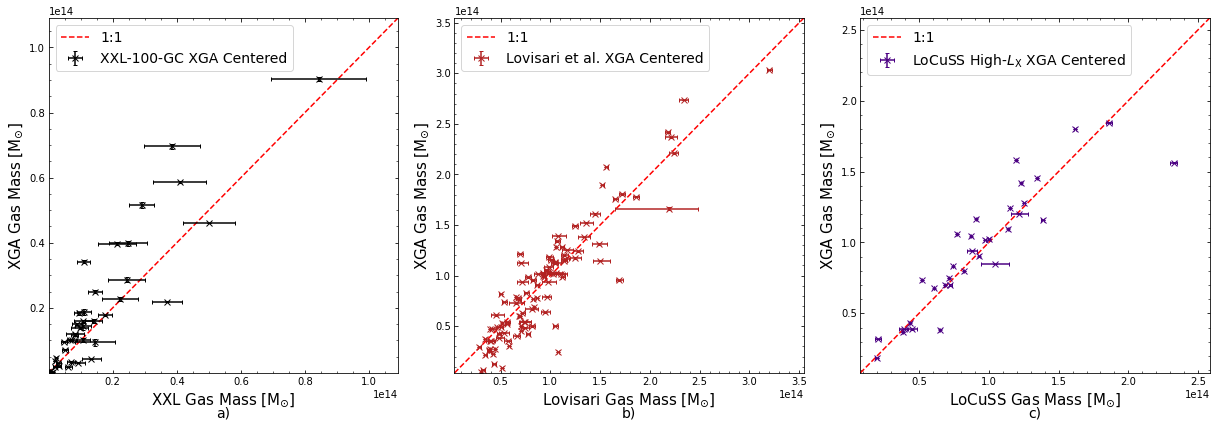

In [24]:
# Setting the y-position and font size of the a, b, and c labels that are added below the subplots
sublabel_ypos = -0.115
sublabel_fsize = 14

# Set up the matplotlib figure with 3 columns, meaning three subplots
fig, ax_arr = plt.subplots(ncols=3, figsize=(17, 6))

# Iterating through the array of axes objects, setting up the ticks
for ax in ax_arr:
    ax.minorticks_on()
    ax.tick_params(which='both', top=True, right=True, direction='in')

# Reading out the first axis in the array of axes
ax = ax_arr[0]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
xxl_lims = find_lims(xc_xxl_lit_gms, xc_xxl_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(xxl_lims, xxl_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xc_xxl_lit_gms[:, 0].value, xc_xxl_dblbeta_svikh_13_gm[:, 0].value, xerr=xc_xxl_lit_gms[:, 1].value, 
             yerr=xc_xxl_dblbeta_svikh_13_gm[:, 1:].T.value, fmt='x', 
             color=xxl_colour, capsize=2, label="XXL-100-GC XGA Centered")

# # Labelling axes, setting labels etc.
ax.set_xlabel(r"XXL Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(xxl_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(xxl_lims)

# Add the a) label below this first plot
ax.text(0.5, sublabel_ypos, s='a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the second axis in the array of axes
ax = ax_arr[1]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
lov_lims = find_lims(xc_lov_lit_gms, xc_lov_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(lov_lims, lov_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xc_lov_lit_gms[:, 0].value, xc_lov_dblbeta_svikh_13_gm[:, 0].value, 
             xerr=xc_lov_lit_gms[:, 1:].T.value, 
             yerr=xc_lov_dblbeta_svikh_13_gm[:, 1:].T.value, fmt='x', 
             color=lov_colour, capsize=2, label="Lovisari et al. XGA Centered")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"Lovisari Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(lov_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(lov_lims)
ax.text(0.5, sublabel_ypos, s='b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Reading out the last axis in the array of axes
ax = ax_arr[2]
plt.sca(ax)

# Fetching appropriate limits for comparing the two sets of gas-mass measurements
loc_lims = find_lims(xc_loc_lit_gms, xc_loc_dblbeta_svikh_13_gm).value

# Plotting a 1:1 line to help with comparisons
plt.plot(loc_lims, loc_lims, color='red', linestyle="dashed", label="1:1")
# Plotting the two datasets with uncertainties
plt.errorbar(xc_loc_lit_gms[:, 0].value, xc_loc_dblbeta_svikh_13_gm[:, 0].value, 
             xerr=xc_loc_lit_gms[:, 1].value, 
             yerr=xc_loc_dblbeta_svikh_13_gm[:, 1].T.value, fmt='x', 
             color=loc_colour, capsize=2, label=r"LoCuSS High-$L_{\rm{X}}$ XGA Centered")

# Labelling axes, setting labels etc.
ax.set_xlabel(r"LoCuSS Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_xlim(loc_lims)
ax.set_ylabel("XGA Gas Mass [M$_{\odot}$]", fontsize=15)
ax.set_ylim(loc_lims)
ax.text(0.5, sublabel_ypos, s='c)', horizontalalignment='center', verticalalignment='center', 
        transform=ax.transAxes, fontsize=sublabel_fsize)
ax.legend(loc='best', fontsize=14)

# Saving and plotting the resulting figure
plt.tight_layout()
plt.savefig("non_paper_figures/xxl_lov_loc_dblbeta_svikh_1.3r500_xgacent_gm_comp.pdf")
plt.show()